In [49]:
import os
import math
import cv2
import pytube as pyt
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
#Needs ffmpeg for audio, I think you can add that to AWS directly, if not just zip executable I think

In [52]:
class YoutubePlaylist:
    """class with all the code, initialize with the playlist link, a name,and a folderpath,  as str"""
    def __init__(self,link,name,MainFolder):
        self.Playlist=pyt.Playlist(link)
        self.name=name
        self.streams=[]
        self.MainFolder=MainFolder
        self.mp4folder=None
        self.mp4names=[]
        self.fps=[]
        self.videonames=[]
        self.FrameFolder=None
        self.AudioFolder=None
        self.SpectFolder=None
        if not os.path.exists(self.MainFolder):
            os.mkdir(self.MainFolder)
    #run playlist_download before anything else

    def playlist_download(self,mp4folder='/mp4',start=0,stop=False,tries=50,pr=False):
        """Downloads all videos from the linked playlist to a folder Defined by mp4folder. name is for the file names"""
        if not os.path.exists(self.MainFolder+mp4folder):
            os.mkdir(self.MainFolder+mp4folder)
        self.mp4folder=mp4folder
        if not stop:
            rnge=self.Playlist.videos[start:]
        else:
            rnge=self.Playlist.videos[start:stop]
        for number, video in enumerate(rnge):
            p=1
            while p>0 and p<tries:
                try:
                    a=video.streams.filter(file_extension='mp4').first()
                    p=-1
                except:
                    try:
                        a=video.streams.filter(file_extension='mp4').first()
                        p=-1
                    except:
                        try:
                            a=video.streams.filter(file_extension='mp4').first()
                            p=-1
                        except:
                            if pr:
                                print(f'Attempt{p}')
                            p=p+1
            self.streams.append(a)
            self.mp4names.append(f'{self.name}_video{number}.mp4') 
            self.streams[number].download(self.MainFolder+mp4folder,filename=f'{self.name}_video{number}.mp4') #downloads mp4 to folder 
            self.fps.append(self.streams[number].fps)
            self.videonames.append(video.title)
        

    def frame(self,videonumber,time,FrameFolder='/Frames'):
        """downloads single frame from a video. Inputs video number from the playlist, and time in the video in seconds.
        This is mainly for convenience/troubleshooting, should probably just get from whole playlist at once"""
        self.FrameFolder=FrameFolder #be consistent with FrameFolder between functions, didn't think that through
        if not os.path.exists(self.MainFolder+self.FrameFolder):
            os.mkdir(self.MainFolder+self.FrameFolder)
        cam = cv2.VideoCapture(self.MainFolder+self.mp4folder+'/'+self.mp4names[videonumber])
        maxframes=cam.get(7)
        frame_viewed=math.floor(time*self.fps[videonumber])
        if frame_viewed>maxframes:
            print ("max frames exceeded")
        cam.set(1, frame_viewed)
        ret,frame = cam.read()
        filename=f'/{self.name:.3}_video{videonumber:02}_frame{frame_viewed:08}.jpg'
        cv2.imwrite(self.MainFolder+FrameFolder+filename,frame) #might be better format than jpg
        
    def bunch_frame(self,videonumber,times,FrameFolder='/Frames'):
        """same as frame_download_video but takes in list for times (in secodns) instead. Could easily combine them but too lazy now"""
        self.FrameFolder=FrameFolder
        for time in times:
            self.frame(videonumber,time,FrameFolder)
            
    def playlist_frame(self,timestep=5,FrameFolder='/Frames'):
        """downloads frames from each video in playlist at every time step, input timestep and FrameFolder"""
        for videonumber in range(np.size(self.streams)):
            cam = cv2.VideoCapture(self.MainFolder+self.mp4folder+'/'+self.mp4names[videonumber])
            maxtime=cam.get(7)/self.fps[videonumber]
            times=np.arange(0,maxtime,timestep)
            self.bunch_frame(videonumber,times,FrameFolder)
            
    def sound(self,videonumber,timestart,timelength,AudioFolder='/Audio'):
        """Takes videonumber, timestart and stop in seconds, AudioFolder, downloads that as wav"""
        self.AudioFolder=AudioFolder
        source=self.MainFolder+self.mp4folder+'/'+self.mp4names[videonumber]
        cam = cv2.VideoCapture(source)
        maxtime=cam.get(7)/self.fps[videonumber]
        if not os.path.exists(self.MainFolder+AudioFolder):
            os.mkdir(self.MainFolder+AudioFolder)
        start=str(timedelta(seconds=int(timestart)))
        if timestart+timelength>maxtime:
            print("max time exceeded")
        else:
            audioname=self.MainFolder+AudioFolder+f'/{self.name:.3}_video{videonumber:02}_Audio{timestart*self.fps[videonumber]:08}.wav'
            command=' ffmpeg -y -ss {} -t {} -i {} -ac 2 -f wav {}'.format(start,int(timelength),source,audioname)
            os.system(command)
    def bunch_sound(self,videonumber,timegap=600,timelength=5,starttrim=0,endtrim=0,AudioFolder='/Audio'):
        """Downloads wav of length timelength every timegap from videonumber,can trim off start and end, use integers to be safe idk"""
        source=self.MainFolder+self.mp4folder+'/'+self.mp4names[videonumber]
        cam = cv2.VideoCapture(source)
        maxtime=cam.get(7)/self.fps[videonumber]
        for timestart in range(int(starttrim),int(maxtime-endtrim-timelength-1),int(timegap)):
            self.sound(videonumber,timestart,timelength,AudioFolder=AudioFolder)
    def playlist_sound(self,timegap=600,timelength=5,starttrim=0,endtrim=0,AudioFolder='/Audio'):
        """"Does what bunch_sound does except interated through every video"""
        parameters=(timegap,timelength,starttrim,endtrim,AudioFolder)
        for videonumber in range(np.size(self.streams)):
            self.bunch_sound(videonumber,*parameters)
    def sounds_to_spectogram(self,SpectogramFolder='/Spect'):
        self.SpectFolder=SpectogramFolder
        filepath=self.MainFolder+self.AudioFolder
        if not os.path.exists(self.MainFolder+SpectogramFolder):
            os.mkdir(self.MainFolder+SpectogramFolder)
        audio_files=os.listdir(filepath)
        for file in audio_files:
            sample_rate, samples = wavfile.read(filepath+f'/{file}')
            for i in [0,1]:
                frequencies, times, spectrogram = signal.spectrogram(samples[:,i], sample_rate)
                plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
                plt.savefig(self.MainFolder+SpectogramFolder+'/'++f'{i}'+file.replace('wav','jpg'))
        

## Set test to True when trying this out. Setting it to False will download all the playlists and take more frequent sampling of time, which will take a while and a lot of space

Attempt1
Attempt2
Attempt3
Attempt4
Attempt5
Attempt6
Attempt7
Attempt8
Attempt9
Attempt10
Attempt11
Attempt12
Attempt13
Attempt14
Attempt15
Attempt16
Attempt17
Attempt18
Attempt19
Attempt20
Attempt21
Attempt22
Attempt23
Attempt24
Attempt25
Attempt26
Attempt27
Attempt28
Attempt29


<ipython-input-52-f7d501f6f1d1>:120: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
<ipython-input-52-f7d501f6f1d1>:120: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))


Attempt1
Attempt2
Attempt3
Attempt4
Attempt5
Attempt6
Attempt7
Attempt8
Attempt9
Attempt10
Attempt11
Attempt12
Attempt13
Attempt14
Attempt15
Attempt16
Attempt17
Attempt18
Attempt19
Attempt20
Attempt21
Attempt22
Attempt23
Attempt24
Attempt25
Attempt26
Attempt27
Attempt28
Attempt29
Attempt30
Attempt31
Attempt32
Attempt33
Attempt34
Attempt35
Attempt36
Attempt37
Attempt38
Attempt39
Attempt40
Attempt41
Attempt42
Attempt43
Attempt44
Attempt45
Attempt46
Attempt47
Attempt48
Attempt49
Attempt50
Attempt51
Attempt52
Attempt53
Attempt54
Attempt55
Attempt56
Attempt57
Attempt58
Attempt59
Attempt60
Attempt61
Attempt62
Attempt63
Attempt64
Attempt65
Attempt66
Attempt67


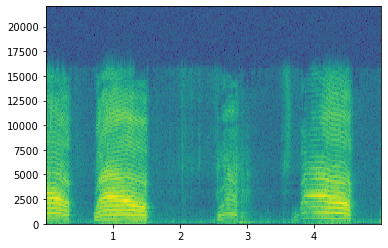

In [53]:
Test=True
Animals=['dog', 'bird', 'cow', 'cat', 'sheep', 'lion', 'snake' ,'elephant', 'pig','monkey']
Links=['https://www.youtube.com/playlist?list=PLEw5hl9-ByjK0GegNAyxTmyJnaChDLUBn',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjISKxRNWsqIZHP6GJrQdDb0',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjJYtcLEmEJdYkhaybovwseu',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjIYk9eSScf04vh8rHhK_vvv',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjLraRvQLhMArkm9z3vaWwjj',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjL3s1r80NaLm1A5qT4U-acx,',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjKNoS90ftpT9YwX1sg6PFc_',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjKZILh4-T082Z15Oar32AJE',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjL1RGnNiO5X_EHiw-EV0lo-',
       'https://www.youtube.com/playlist?list=PLEw5hl9-ByjJpLDDrR52_lcGRTTthX-oU']
timegap=10
pr=False
if Test:
    Animals=[Animals[0],Animals[3]]
    Links=[Links[0],Links[3]]
    timegap=300
    pr=True
things=[]
for i,link in enumerate(Links):
    things.append(YoutubePlaylist(link,Animals[i],f'./{Animals[i]}'))
    things[i].playlist_download(start=0,stop=1,tries=150,pr=pr) #pytube is annoying with downloading videos, tries is how many attempts to download before giving error
    things[i].playlist_frame(timestep=600)
    things[i].playlist_sound(timegap=timegap)
    things[i].sounds_to_spectogram()
    
spect=[]
zeros=[]
name=[]
for animal in Animals:
    filepath='./'+animal
    spect_files=os.listdir(filepath+'/Spect')
    for i in spect_files:
        name.append(animal)
        spect.append(i)
        zeros.append(0)
d = {'image_name':spect, 'comment_number': zeros,'comment':name}
df=pd.DataFrame(data=d)
df.to_csv('./results.csv',sep='|')